# Explorative study on attenuation densities in the lungs

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from tabulate import tabulate
from helper_functions import *


In [2]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [3]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
file_paths = glob.glob(cropped_lung_ct_path)

### Load data of attenuation arrays with vessels

In [4]:
# List the files in the attenuation directory
rows = []
for path in file_paths:
    arr = load_nifti_convert_to_numpy(input_path=path).flatten()
    arr = arr[arr > -4000]
    patient_id = os.path.basename(path)[7:10]
    new_row = {
        'attenuation': arr,
        'patient': patient_id,
        'label': 'w_ggo' if int(patient_id) < 14 else 'wo_ggo',
        'average_attenuation': np.mean(arr),
        'hpdr': get_hpdr(arr),
    }
    rows.append(new_row)

In [5]:
df = pd.DataFrame(rows).sort_values('patient')
df = df.reset_index(drop=True)

In [6]:
df

,attenuation,patient,label,average_attenuation,hpdr
0,"[-222, -158, -72, 29, 150, 284, -240, -149, -3...",000,w_ggo,-777.965251,19.692694
1,"[290, 279, 263, 197, 111, 10, -80, -119, -112,...",001,w_ggo,-816.591181,9.258691
2,"[-171, -171, -172, -176, -155, -115, -67, -7, ...",002,w_ggo,-819.092600,11.402953
3,"[-231, -115, 36, -263, -145, 11, -285, -178, -...",003,w_ggo,-779.915646,16.043169
4,"[121, 91, 57, 5, -49, -82, 87, 52, 12, -48, -9...",004,w_ggo,-812.442461,11.600724
5,"[-28, 17, 43, 71, 94, 83, -137, -120, -104, -7...",005,w_ggo,-772.685866,15.504725
6,"[-778, -695, -562, -724, -610, -488, -633, -51...",006,w_ggo,-821.236600,12.904768
7,"[-204, -214, -210, -209, -197, -184, -175, -16...",007,w_ggo,-795.361991,12.368397
8,"[-81, -100, -96, -113, -140, -175, -199, -179,...",008,w_ggo,-827.418667,9.123034
9,"[-243, -202, -159, -292, -242, -194, -329, -26...",009,w_ggo,-846.603003,7.512526


# Investigating attenuation

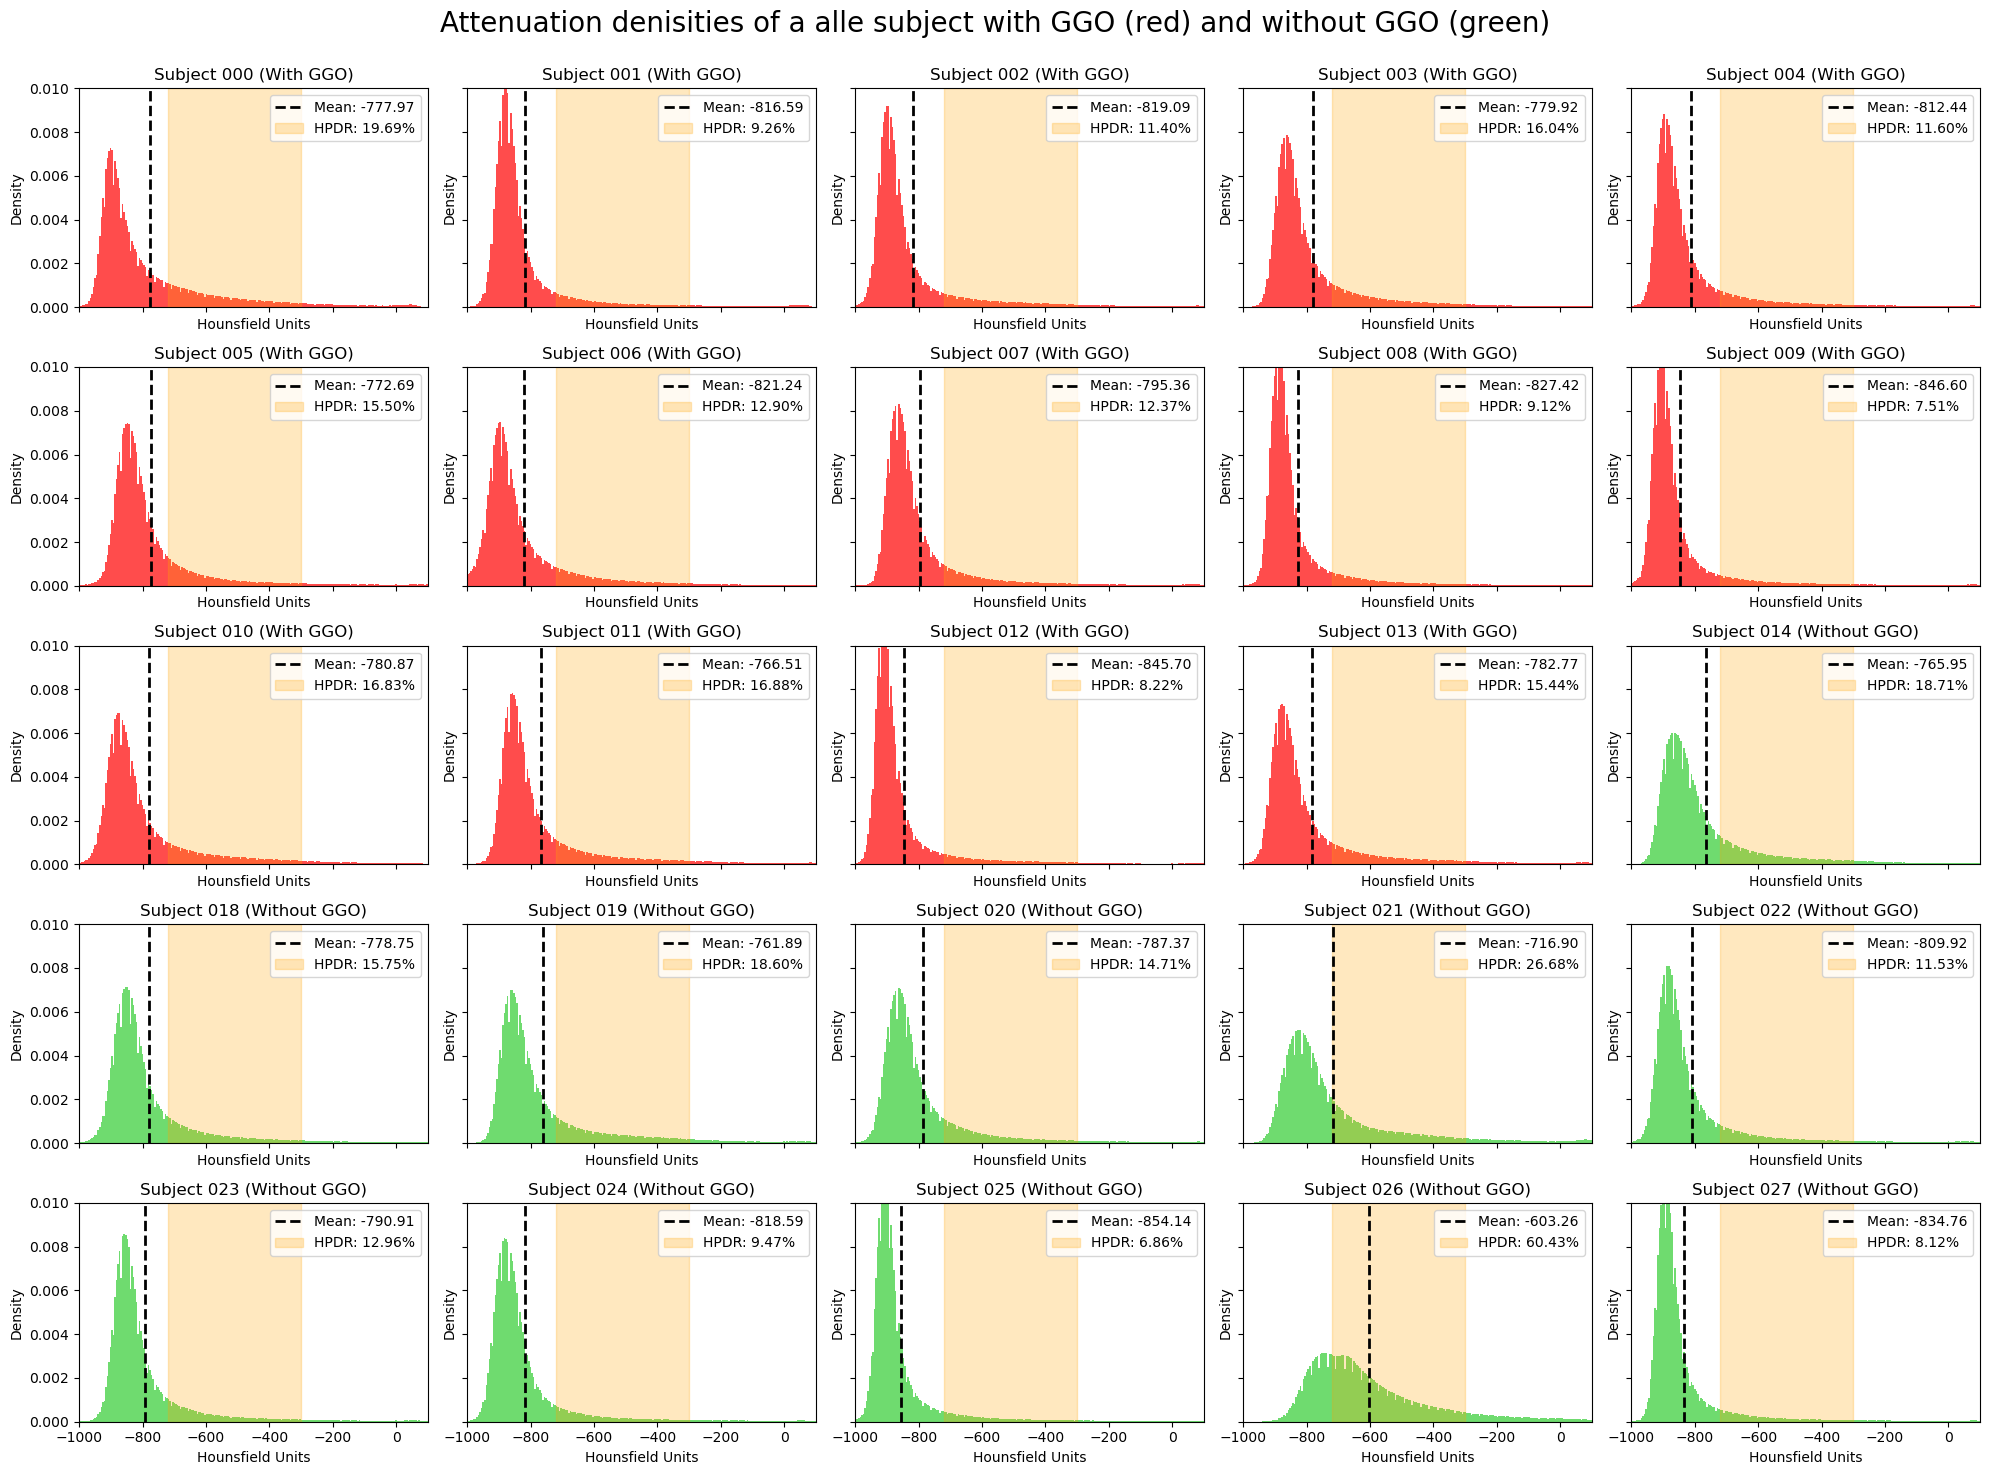

In [7]:
# Calculate the number of plots required (5 columns per row)
cols = 5
rows = 5 

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'red' if label == 'w_ggo' else 'limegreen'
    title = 'With GGO' if label == 'w_ggo' else 'Without GGO'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Subject {patient_id} ({title})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, 100)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Attenuation denisities of a alle subject with GGO (red) and without GGO (green)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

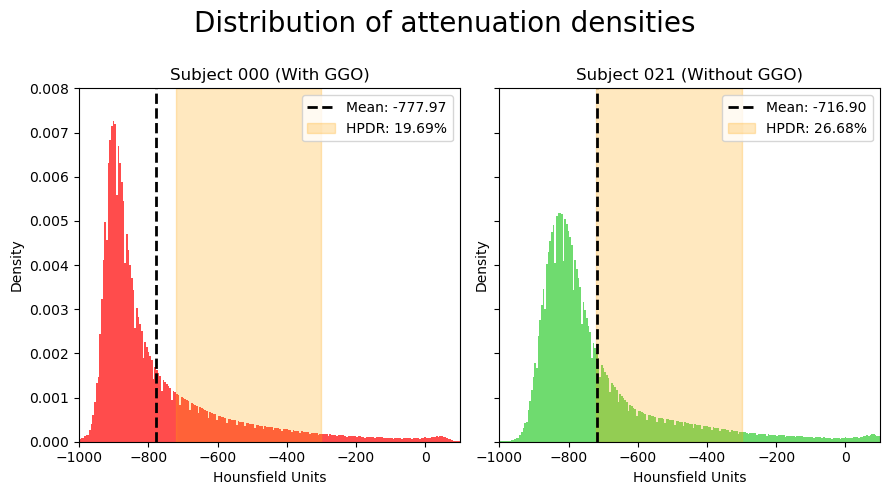

In [16]:
df_subset = df.iloc[[0, 18]]

cols = 2
rows = 1

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(9, 5), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df_subset.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'red' if label == 'w_ggo' else 'limegreen'
    title = 'With GGO' if label == 'w_ggo' else 'Without GGO'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Subject {patient_id} ({title})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.008)
    axes[subplot_idx].set_xlim(-1000, 100)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Distribution of attenuation densities', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Distribution of average attenuations and HPDR (boxplots)

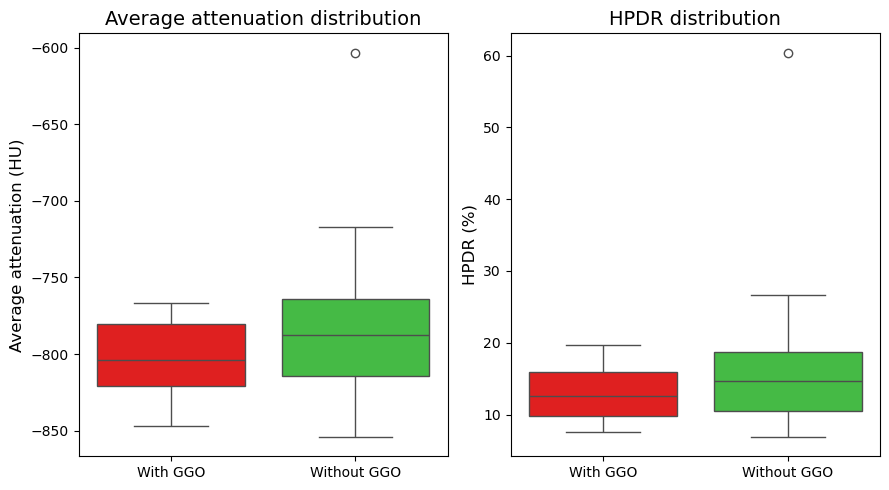

In [9]:
# Define colors and labels
custom_palette = {'Without GGO': 'limegreen', 'With GGO': 'red'}

# Create a copy of the dataframe with labels mapped for prettier x-axis
df['Group'] = df['label'].map({'wo_ggo': 'Without GGO', 'w_ggo': 'With GGO'})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

# Boxplot: attenuation
sns.boxplot(
    data=df,
    x='Group',  # Use 'Group' for x-axis
    y='average_attenuation',
    hue='Group',  # Assign 'Group' to hue
    palette=custom_palette,
    ax=ax1,
    legend=False  # Disable the legend
)
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Average attenuation (HU)', fontsize=12)
ax1.set_title('Average attenuation distribution', fontsize=14)

# Boxplot: HPDR
sns.boxplot(
    data=df,
    x='Group',
    y='hpdr',
    hue='Group', 
    palette=custom_palette,
    ax=ax2,
    legend=False  # Disable the legend
)
ax2.set_xlabel('', fontsize=12)
ax2.set_ylabel('HPDR (%)', fontsize=12)
ax2.set_title('HPDR distribution', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


# Statistical tests

I firstly remove the outlier (subject 026)

In [10]:
df_subset = df[df['patient'] != '026']

## Confidence interval for average attenuation densities

In [11]:
grouped_attenuation = df_subset.groupby('label')['average_attenuation']
mean_att = grouped_attenuation.mean()
sem_att = grouped_attenuation.sem()
n_att = grouped_attenuation.count()
df_att = n_att - 1
t_critical_att = stats.t.ppf(0.975, df_att)
ci_lower_att = mean_att - t_critical_att * sem_att
ci_upper_att = mean_att + t_critical_att * sem_att

ci_df_att = pd.DataFrame({
    'mean': mean_att,
    'SEM': sem_att,
    'CI Lower': ci_lower_att,
    'CI Upper': ci_upper_att
})

# Second metric: hpdr
grouped_hpdr = df_subset.groupby('label')['hpdr']
mean_hpdr = grouped_hpdr.mean()
sem_hpdr = grouped_hpdr.sem()
n_hpdr = grouped_hpdr.count()
df_hpdr = n_hpdr - 1
t_critical_hpdr = stats.t.ppf(0.975, df_hpdr)
ci_lower_hpdr = mean_hpdr - t_critical_hpdr * sem_hpdr
ci_upper_hpdr = mean_hpdr + t_critical_hpdr * sem_hpdr

ci_df_hpdr = pd.DataFrame({
    'mean': mean_hpdr,
    'SEM': sem_hpdr,
    'CI Lower': ci_lower_hpdr,
    'CI Upper': ci_upper_hpdr
})


In [12]:
print("Mean, SEM, and 95% CI for Average Attenuation:")
print(tabulate(ci_df_att, headers=["Label", "Mean", "SEM", "CI Lower", "CI Upper"], tablefmt="fancy_grid", floatfmt=".3f"))

print("\n" + "=" * 80 + "\n")

print("Mean, SEM, and 95% CI for HPDR:")
print(tabulate(ci_df_hpdr, headers=["Label", "Mean", "SEM", "CI Lower", "CI Upper"], tablefmt="fancy_grid", floatfmt=".3f"))


Mean, SEM, and 95% CI for Average Attenuation:
╒═════════╤══════════╤════════╤════════════╤════════════╕
│ Label   │     Mean │    SEM │   CI Lower │   CI Upper │
╞═════════╪══════════╪════════╪════════════╪════════════╡
│ w_ggo   │ -803.226 │  7.245 │   -818.878 │   -787.575 │
├─────────┼──────────┼────────┼────────────┼────────────┤
│ wo_ggo  │ -791.918 │ 12.535 │   -820.275 │   -763.562 │
╘═════════╧══════════╧════════╧════════════╧════════════╛


Mean, SEM, and 95% CI for HPDR:
╒═════════╤════════╤═══════╤════════════╤════════════╕
│ Label   │   Mean │   SEM │   CI Lower │   CI Upper │
╞═════════╪════════╪═══════╪════════════╪════════════╡
│ w_ggo   │ 13.055 │ 1.002 │     10.890 │     15.220 │
├─────────┼────────┼───────┼────────────┼────────────┤
│ wo_ggo  │ 14.340 │ 1.885 │     10.077 │     18.604 │
╘═════════╧════════╧═══════╧════════════╧════════════╛


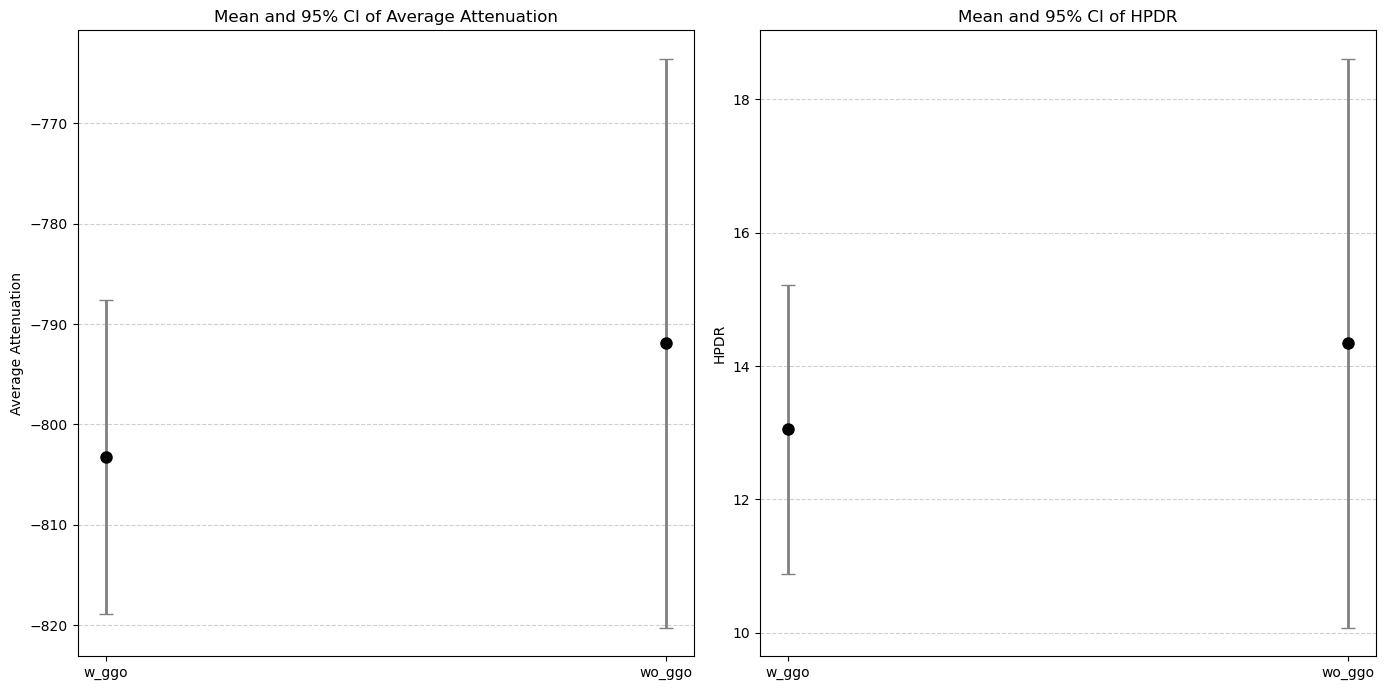

In [13]:
labels = ci_df_att.index
mean_att = ci_df_att['mean']
sem_att = ci_df_att['SEM']
ci_lower_att = ci_df_att['CI Lower']
ci_upper_att = ci_df_att['CI Upper']

mean_hpdr = ci_df_hpdr['mean']
sem_hpdr = ci_df_hpdr['SEM']
ci_lower_hpdr = ci_df_hpdr['CI Lower']
ci_upper_hpdr = ci_df_hpdr['CI Upper']

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].errorbar(labels, mean_att, 
                 yerr=[mean_att - ci_lower_att, ci_upper_att - mean_att],
                 fmt='o', capsize=5, color='black', ecolor='gray', elinewidth=2, markersize=8)
axes[0].set_title('Mean and 95% CI of Average Attenuation')
axes[0].set_ylabel('Average Attenuation')
axes[0].set_xlabel('')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].errorbar(labels, mean_hpdr, 
                 yerr=[mean_hpdr - ci_lower_hpdr, ci_upper_hpdr - mean_hpdr],
                 fmt='o', capsize=5, color='black', ecolor='gray', elinewidth=2, markersize=8)
axes[1].set_title('Mean and 95% CI of HPDR')
axes[1].set_ylabel('HPDR')
axes[1].set_xlabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Let's test the nul-hypothesis: there is no significant difference between the means of the two groups.

Alternative hypothesis: There is a significant difference between the means of the two groups.

In [14]:
# Divide into groups
avg_att_w_ggo = df_subset[df_subset['label'] == 'w_ggo']['average_attenuation']
avg_att_wo_ggo = df_subset[df_subset['label'] == 'wo_ggo']['average_attenuation']

hpdr_w_ggo = df_subset[df_subset['label'] == 'w_ggo']['hpdr']
hpdr_wo_ggo = df_subset[df_subset['label'] == 'wo_ggo']['hpdr']

In [15]:
# Perform two-sample t-tests
t_stat_att, p_val_att = ttest_ind(avg_att_w_ggo, avg_att_wo_ggo, equal_var=True)  # For average_attenuation
t_stat_hpdr, p_val_hpdr = ttest_ind(hpdr_w_ggo, hpdr_wo_ggo, equal_var=True)  # For hpdr

# Display results
print(f"T-test for Average Attenuation: t = {t_stat_att:.3f}, p = {p_val_att:.3f}")
print(f"T-test for HPDR: t = {t_stat_hpdr:.3f}, p = {p_val_hpdr:.3f}")


T-test for Average Attenuation: t = -0.832, p = 0.414
T-test for HPDR: t = -0.649, p = 0.523


Based on the t-test results, we conclude that there is no significant difference in either the average attenuation or the HPDR between the two groups.